In [ ]:
import os
pwd = os.getcwd()

pwd

In [ ]:
import pandas as pd
import numpy as np
import sys

if "/home/" in pwd:
    sys.path.insert(0, "./utils")
    sys.path.insert(0, "/mnt/d/cloud/unizg/OneDrive - Faculty of Graphic Arts of University of Zagreb/poligon/Pocket ML/utils")
elif "\\cloud\\" in pwd:
    sys.path.insert(0, "../utils")


from workbench import Stats

### Učitavanje podataka iz triju baza

Sve tri baze su unaprijed pripremljene preko `wikiart-setup.py`, `wikiart-emotions-setup.py` i moćnih ručno izrađenih alata za baratanje ovim bazama smještenih u `../../utils` direktoriju.

WikiArt baza je ta koja je pripremljena s već kategoriziranim stilovima. Ta kategorizacija nije nužno idealna i vjerojatno će ju trebati ponoviti, ali na probranom uzorku izložaka jer, čini mi se, nema razloga teretiti cijelu bazu već samo uzorak za trening i testiranje.


In [ ]:
wikiart = Stats(data_url="./data/wikiart_paintings.parquet", title="Wikiart")
emotions = Stats(data_url="./data/Wikiart-Emotions-All-t.parquet", title="Wikiart-emotions")
artemis = Stats(data_url="./data/artemis_dataset_release_v0-t2.parquet", title="ArtEmis")

### Spajanje WikiArt baze s Artemis bazom


In [ ]:
mappings = wikiart.raw_data.merge(artemis.raw_data.rename(columns={"emotion":"artemis", "Artist": "artistName", "Title": "title"})[["artistName", "title", "artemis"]], on=["artistName", "title"], how="left")
mappings.dropna(subset=["artemis"]).shape, artemis.raw_data.shape

### Spajanje WikiArt-Artemis baze s WikiArt_emotions bazom


In [ ]:
emotions_cols = emotions.raw_data[['emotion', 'Is painting', 'Face/body', 'Rating', "Title", "Artist", "Year", 'webUrl']].rename(columns={"emotion": "emotions", "Title": "title", "Artist": "artistName", "webUrl": "webUrl2"})
mappings_em = mappings.merge(emotions_cols, on=["artistName", "title"], how="left")

mappings_em.dropna(subset=["emotions"]).shape, emotions_cols.shape

### Čišćenje i optimiziranje


In [ ]:
# from styles import style_categories as styles
int_columns = ['Icon', 'Realism', 'Romanticism', 'Impressionism', 'Expressionism', 'Surrealism', 'Naive Art', 'Fauvism', 'Brutalism', 'Dada', 'Cubism',
    'Abstract Order', 'Abstract Chaos', 'Applied Art', 'Oriental Illustration', 'Photography', 'abstract', 'painting', 'drawing', 'composit', 'applied art', 'photography']
large_int_columns = [ 'contentId', 'artistContentId' ]
mappings_em[ int_columns ] = mappings_em[ int_columns ].astype(np.int8)
mappings_em[ large_int_columns ] = mappings_em[ large_int_columns ].astype(np.int64)

In [ ]:
mappings_em.year = mappings_em.year.apply(pd.to_numeric).astype("Int64")
mappings_em.sample(5)

In [ ]:
mappings_em = mappings_em.set_index("contentId")

In [ ]:
cat_columns = [ "style", "genre", "Is painting", "Face/body"]
mappings_em[ cat_columns ] = mappings_em[ cat_columns ].astype("category")
mappings_em.sample(5)

### Pohranjivanje kompozitne baze


In [ ]:
mappings_em.shape

In [ ]:
mappings_em[['artistName', 'title', 'year', 'style', 'genre', 'photography', 'artemis', 'emotions',
       'Is painting', 'Face/body', 'Rating', 'artistContentId',
       'artistUrl', 'url', 'localUrl', 'webUrl', 'webUrl2']].rename(columns={"url": "paintingUrl"}).to_parquet("./data/wikiart_composed.parquet")

## Učitavanje baze, skidanje slikovnog materijala, treniranje i testiranje


In [1]:
# provjera postavki
import torch
print(f"CUDA is available: {torch.cuda.is_available()}.", f"Activated version of CUDA is {torch.version.cuda}.", torch.cuda.device(0))
print(f"Volta's gencode (sm_86) for RTX 3050 and 3070 is in arch_list: {'sm_86' in torch.cuda.get_arch_list()}.")

CUDA is available: True. Activated version of CUDA is 12.1. <torch.cuda.device object at 0x7f0faa4a2d50>
Volta's gencode (sm_86) for RTX 3050 and 3070 is in arch_list: True.


In [1]:
import pandas as pd
from fastai.vision.all import Path
from utils.downloader import image_downloader


root = Path("./")
# from utils.previewer import preview_image_grid

categories = {
            "breath": {
                    "abstract": ['Hard Edge Painting', "Concretism", "Suprematism", "Abstract Art", "Abstract Expressionism", "Action painting"], # "Constructivism", 
                    "concrete": ["Northern Renaissance", "Hyper-Realism", "Tenebrism", "Academicism", "Classical Realism", "Naturalism", "Baroque" ] # "Rococo"
                },
            "depth": {
                    "symbolic": ["International Gothic", "Byzantine", "Pop Art", "High Renaissance", "Classicism", "Mannerism \(Late Renaissance\)", "Romanesque" ], 
                    "iconic": ["Color Field Painting", "Abstract Expressionism", "Action painting", "Lyrical Abstraction", "Post-Impressionism", "Analytical Realism", "Academicism", "Rococo", "Pointillism"] # "Art Deco", "Art Nouveau \(Modern\)"
                }
        }

# preview_image_grid(df=pd.read_parquet("./data/wikiart_composed.parquet"), taste="Naturalism" ) # categories["depth"]["iconic"][4]

#### Skidanje slika po kategorijama


In [2]:
container, categories = image_downloader(root, base="wikiart_composed", categories=categories, sample_size=500, image_size=224, skip_downloads=True)


 Neispravnih: 0


#### Priprema DataLoaders-a za modele


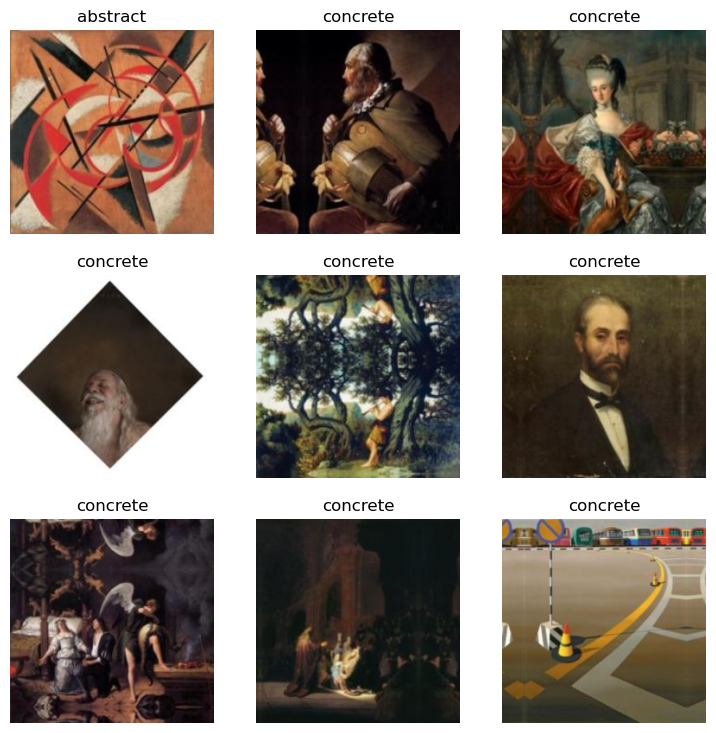

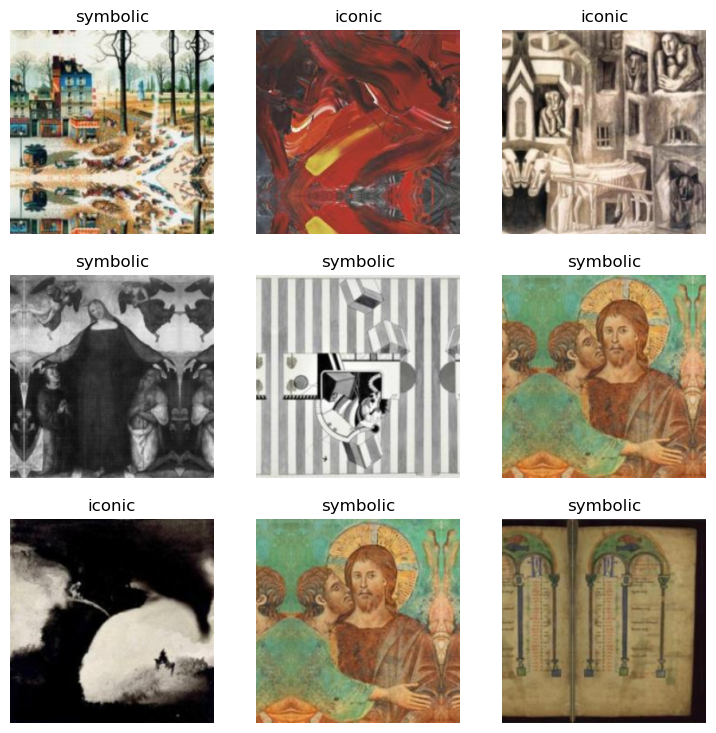

In [3]:
from utils.learners import create_dataloaders

dls = create_dataloaders(container, categories)

#### Izbor i trening modela na podatcima


In [ ]:
from fastai.vision import models
from utils.learners import create_learners, train_learners

# "alexnet"
# ovi na žalost iz nekog razloga ne idu, a trebali bi biti najbrži (levit) --> "vit_b_16" (najmanji), "vit_b_32", "vit_l_32" (veliki), "vit_h_14" (najveći)
# ne rade ni ovi --> "inception_v3", "densenet", "swin_v2_b"
# "resnet18", "resnet34", "resnet50", ,
# "xresnet18",  "xresnet18_deeper",  "xresnet34",  "xresnet34_deeper", "xresnet50", "xresnet50_deeper", 
# "vgg11_bn", "vgg19_bn" (iz nekog razloga ne mogu veći od 11)
# "convnext_tiny", "convnext_base", "convnext_large" (najbolje radi na 3 epohe, ne će veće od tiny)
model_pick = "swin_v2_b" 

# (v. https://github.com/fastai/fastai/tree/master/fastai/vision/models)

if model_pick.__contains__("xresnet"):
    model = getattr(models.xresnet, model_pick )    
elif model_pick.__contains__("unet"):
    model = getattr(models.unet, model_pick ) 
elif model_pick.__contains__("tvm"):
    model = getattr(models.tvm, model_pick ) 
else:
    model = getattr(models, model_pick ) 

learners = create_learners(dls, model=model)

train_learners(learners, iters=3, lr=None)

# spremi model na disk
garage = Path(f"./models/{model_pick}")

if not garage.exists():
    garage.mkdir()

learners["breath"].export(garage/"breath.pkl")
learners["depth"].export(garage/"depth.pkl")

In [ ]:
models.swin_v2_b

## Testiranje modela


In [6]:
from utils.tester import test_learners
from utils.downloader import page_scraper
from fastai.vision.all import Path, load_learner
import os
from pprint import pformat

# model_picks = next(os.walk("./models"))[1]
model_picks = ["resnet18"]
root = Path("./")
seen = set()
testees = {}


for model in model_picks:
    garage = Path(f"./models/{model_picks[0]}")
    try: 
        garage = Path(f"./models/{model}")
    except NameError:
        print(f"model was not defined. Going with {model_picks[0]}.")
    signature = pformat(garage)
    if signature not in seen:
        seen.add(signature)
        try:
            testees[model] = {
                "breath": load_learner(garage/"breath.pkl"),
                "depth": load_learner(garage/"depth.pkl")
            }
        except:
            print(f"Model {model} is not trained yet!")

testees

{'resnet18': {'breath': <fastai.learner.Learner at 0x7f145354a850>,
  'depth': <fastai.learner.Learner at 0x7f144d0b2ad0>}}

### Testiranje na web stranicama


In [ ]:

# "https://aiartists.org/generative-art-design"
# "https://unsplash.com"
# "https://www.metmuseum.org/art/collection/search?showOnly=openAccess"
# "https://www.gettyimages.com"

internet = [
    *page_scraper("https://www.gettyimages.com"),
]

# "https://tse2.mm.bing.net/th?id=OIP.UPZ1-G8gpc5FkNIC2RCWSgHaFj&pid=Api",
# "https://tse2.mm.bing.net/th?id=OIP.if_cidFAKZ49wY7BLA3feQHaGE&pid=Api",
# "https://tse4.mm.bing.net/th?id=OIP.Px4ySbgcqEgFJOhOq8k5mAHaEo&pid=Api",
# "https://tse4.mm.bing.net/th?id=OIP.eNfpYf9Oqyh0u3_b1Eu20wHaGL&pid=Api",
# "https://tse3.mm.bing.net/th?id=OIP.NEkbbYyu56hdqekgPKxmoQAAAA&pid=Api",
# "https://tse3.mm.bing.net/th?id=OIF.jw1Qziy4XGJbDtTYtrBY3Q&pid=Api",
# "https://tse2.mm.bing.net/th?id=OIP.pJwVOqij6rPFrOjcHc1jbAHaKj&pid=Api",
# "https://tse1.mm.bing.net/th?id=OIP.-Hy08hdnnfvCwor0Y_fyGAHaLA&pid=Api",
# "https://tse4.mm.bing.net/th?id=OIP.mUVhO-Zld2qEJKe_r9tJaAHaHn&pid=Api",
# "https://tse2.mm.bing.net/th?id=OIP.DqjuCxnocoFQ0hvIH_Cm8wHaEK&pid=Api",
# "https://tse1.mm.bing.net/th?id=OIP.EFoByYTKu1KbZgoVfocCDAHaFU&pid=Api",
# "https://tse2.mm.bing.net/th?id=OIP.BFRcQqZ5Bpw1a-6u_XoBrwHaFj&pid=Api",
# "https://tse2.mm.bing.net/th?id=OIP.2qqjQQ0wW37Lbvkx50zPxgHaEB&pid=Api"

for model_name, testee in testees.items():
    test_learners(testee, test_set=internet, model_name=model_name, root=root/"artefacts", preview=False)

In [16]:
import re 

html = 'aaa a ad <img image="tupo-_&$banana.jpeg 300w, milica0087Pilica.png 120w" /> safdsaf saf\
    \safdafa <img asf afasf srcset="data:image/bmp jJAJBDADHHANDKNDKAKNNDDMNANDMND" src="345a"/> \
    saf sa<img data-stretch="false" data-src="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg" data-image="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg" data-image-dimensions="1500x842" data-image-focal-point="0.5,0.5" alt="Generative Software Design Example - Procedural Modeling.jpeg" data-load="false" src="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg" width="1500" height="842" alt="" sizes="100vw" style="display:block;object-fit: cover; width: 100%; height: 100%; object-position: 50% 50%" srcset="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=100w 100w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=300w 300w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=500w 500w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=750w 750w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=1000w 1000w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=1500w 1500w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=2500w 2500w" loading="lazy" decoding="async" data-loader="sqs">\
     ffasf asf asf <figure srcset= "https://pili?ćsss3245i.png" =src=><div style="background-image: url(http://vilinkonjic.jpeg )" >saf </div> \
        <img data-stretch="false" data-src="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg" data-image="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg" data-image-dimensions="1958x720" data-image-focal-point="0.5,0.5" alt="Silk Interactive Generative Art.jpg" data-load="false" src="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg" width="1958" height="720" alt="" sizes="100vw" style="display:block;object-fit: cover; width: 100%; height: 100%; object-position: 50% 50%" srcset="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=100w 100w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=300w 300w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=500w 500w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=750w 750w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=1000w 1000w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=1500w 1500w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=2500w 2500w" loading="lazy" decoding="async" data-loader="sqs">'

src = "<(?:img|figure)[\s]*.*?(?:src|image)(?:set)?=[\"'\s]+((?:http)[^'\"\s]+(?:.jpg|.jpeg|.png|.gif|,))[^'\"]*?[\"']+.*?>"
bgurl = "url\([\s]*?((?:http)[^\"'\s]+(?:.jpg|.jpeg|.png))[^\"']*?\)"


re.findall(src, html, re.IGNORECASE), re.findall(bgurl, html, re.IGNORECASE)

(['https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg',
  'https://pili?ćsss3245i.png',
  'https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg'],
 ['http://vilinkonjic.jpeg'])

### Testiranje na bazi


In [7]:
import pandas as pd

df = pd.read_parquet("data/wikiart_composed.parquet")
df.head()

,artistName,title,year,style,genre,photography,artemis,emotions,Is painting,Face/body,Rating,artistContentId,artistUrl,paintingUrl,localUrl,webUrl,webUrl2
contentId,,,,,,,,,,,,,,,,,
314345,Hans von Aachen,Augustus and the Tiburtine Sibyl,1580,Mannerism (Late Renaissance),mythological painting,0,None,None,NaN,NaN,NaN,314332,hans-von-aachen,augustus-and-the-tiburtine-sibyl-1580,./wikiart/wikidata/images/hans-von-aachen/1580/314345.jpg,https://uploads6.wikiart.org/images/hans-von-aachen/augustus-and-the-tiburtine-sibyl-1580.jpg!Large.jpg,None
314363,Hans von Aachen,Portrait of Jacopo Biliverti,1585,Mannerism (Late Renaissance),portrait,0,None,None,NaN,NaN,NaN,314332,hans-von-aachen,portrait-of-jacopo-biliverti-1585,./wikiart/wikidata/images/hans-von-aachen/1585/314363.jpg,https://uploads2.wikiart.org/images/hans-von-aachen/portrait-of-jacopo-biliverti-1585.jpg!Large.jpg,None
314364,Hans von Aachen,Portrait of Joseph Heintz,1585,Mannerism (Late Renaissance),portrait,0,None,None,NaN,NaN,NaN,314332,hans-von-aachen,portrait-of-joseph-heintz-1585,./wikiart/wikidata/images/hans-von-aachen/1585/314364.jpg,https://uploads8.wikiart.org/images/hans-von-aachen/portrait-of-joseph-heintz-1585.jpg!Large.jpg,None
314371,Hans von Aachen,The rape of Proserpine,1587,Mannerism (Late Renaissance),mythological painting,0,None,None,NaN,NaN,NaN,314332,hans-von-aachen,the-rape-of-proserpine-1587,./wikiart/wikidata/images/hans-von-aachen/1587/314371.jpg,https://uploads5.wikiart.org/images/hans-von-aachen/the-rape-of-proserpine-1587.jpg!Large.jpg,None
314369,Hans von Aachen,The judgment of Paris,1588,Mannerism (Late Renaissance),mythological painting,0,None,None,NaN,NaN,NaN,314332,hans-von-aachen,the-judgment-of-paris-1588,./wikiart/wikidata/images/hans-von-aachen/1588/314369.jpg,https://uploads4.wikiart.org/images/hans-von-aachen/the-judgment-of-paris-1588.jpg!Large.jpg,None


In [ ]:
from utils.tester import predict_columns

# prođi kroz bazu u malim batchevima i spremi u datoteke
dataset = df.loc[~df["artemis"].isna() | ~df["emotions"].isna()]
datafiles = {}
for model_name, testee in testees.items(): 
    datafiles[model_name] = predict_columns(testee, dataset, model_name, root)

In [ ]:
# spoji kreirane batch datoteke u jednu
for model_name, addresses in datafiles.items():
    result = pd.DataFrame()
    for adress in addresses:
        data = pd.read_parquet(adress)
        result = pd.concat((result, data))

    result[["artistName", "title", "year", "style", "breath", "breath_probs", "depth", "depth_probs", "genre", "artemis", "emotions", "webUrl"]].to_parquet(f"data/{model_name}/critic_full.parquet")